In [7]:
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest

import seaborn as sns
from matplotlib import pyplot as plt

In [8]:
global GROUND_TRUTH
global NUM_CLASSES
GROUND_TRUTH = ['Background', 'Brocoli_green_weeds_1', 'Brocoli_green_weeds_2', 'Fallow', 'Fallow_rough_plow',
                        'Fallow_smooth', 'Stubble', 'Celery', 'Grapes_untrained', 'Soil_vinyard_develop',
                        'Corn_senesced_green_weeds', 'Lettuce_romaine_4wk', 'Lettuce_romaine_5wk',
                        'Lettuce_romaine_6wk', 'Lettuce_romaine_7wk', 'Vinyard_untrained', 'Vinyard_vertical_trellis']
NUM_CLASSES = len(GROUND_TRUTH) - 1

## Load the Salinas dataset

In [9]:
salinas_data = sio.loadmat('./Salinas_corrected.mat')['salinas_corrected']
salinas_labels = sio.loadmat('./Salinas_gt.mat')['salinas_gt']

In [10]:
print(salinas_data.shape)
print(salinas_labels.shape)

(512, 217, 204)
(512, 217)


## Dataset Visualization

### 1. Display the ground truth

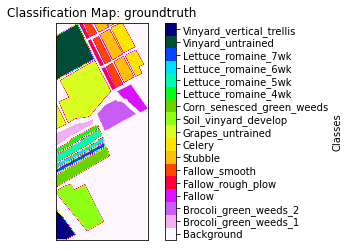

In [11]:
def display_class(data, title=''):
    # this function is from "LEt_SNE_ICASSP2020.ipynb" in "https://github.com/meghshukla/LEt-SNE"
    '''
    NUMPY
    Displays Classification Map
    :param data: 2D Numpy array containing pixel wise labels
    :return: None
    '''
    fig, ax = plt.subplots()

    plt.imshow(data, cmap=plt.cm.get_cmap('gist_ncar_r', NUM_CLASSES + 1))
    plt.title('Classification Map: ' + title)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(label='Classes', boundaries=(np.arange(NUM_CLASSES + 2) - 0.5))
    cbar.set_ticks(np.arange(NUM_CLASSES + 1))
    cbar.set_ticklabels(GROUND_TRUTH)

    return None
display_class(salinas_labels, 'groundtruth')

### 2. Bar chart plot of label distribution

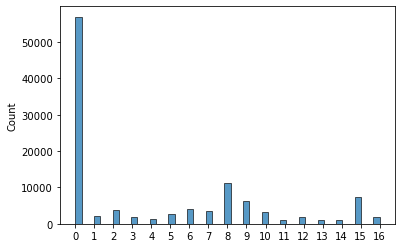

In [14]:
ax_salinas = sns.histplot(salinas_labels.flatten())
plt.xticks(np.arange(17))
plt.show()

## Feature Visualization (whole dataset)

### 1. Plot the curve of one sample

Text(0.5, 1.0, 'Plot the curve of one sample')

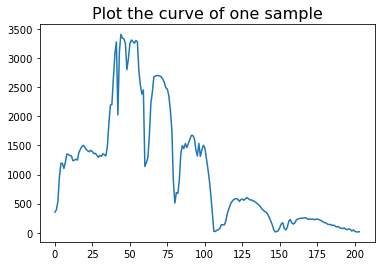

In [15]:
# get any position 
pos = [33,99]
feature = salinas_data[pos[1],pos[0],:]
plt.plot(feature)
plt.title('Plot the curve of one sample', fontdict = {'fontsize': 16})

### 2. Display a composite color image 

ImageView object:
  Display bands       :  (29, 19, 9)
  Interpolation       :  <default>
  RGB data limits     :
    R: [2.0, 8336.0]
    G: [59.0, 9171.0]
    B: [86.0, 8209.0]

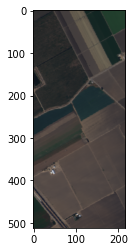

In [16]:
import spectral as spy
spy.imshow(salinas_data,(29, 19, 9))

### 3. Overall Score of All Features

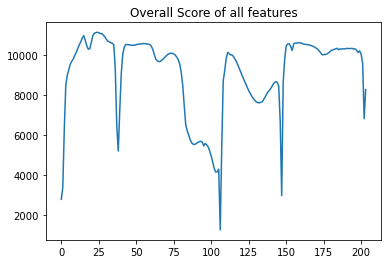

In [17]:
f_importance = SelectKBest(k=1)
f_importance.fit(salinas_data.reshape(-1,salinas_data.shape[2]), salinas_labels.flatten())
plt.plot(f_importance.scores_)
plt.title("Overall Score of all features")
plt.show()

### 4. Feature spaces of different classes

In [18]:
# Select two specific bands
class_index = 8
c1_feature1 = salinas_data[:,:,33][np.where(salinas_labels==class_index)]
c1_feature2 = salinas_data[:,:,99][np.where(salinas_labels==class_index)]

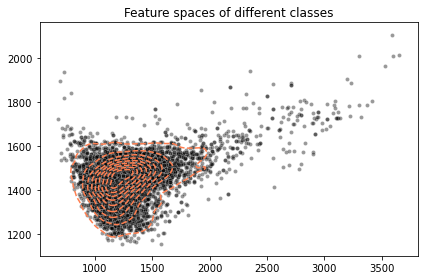

In [19]:
sns.kdeplot(x=c1_feature1, y=c1_feature2,color='coral',linestyles='dashed')
sns.scatterplot(x=c1_feature1, y=c1_feature2, color='black', alpha=0.4, s=16)
plt.title('Feature spaces of different classes')
plt.tight_layout();

## 

## Dataset Pre-possessing

#### Remark: The commented code is a test on our identified limitation:  Adding a Gaussian Blurring

In [20]:
# from skimage.filters import gaussian
# salinas_data_blur = gaussian(salinas_data, sigma=5, channel_axis=True)

In [21]:
# salinas_data_blur.shape

### 1. Merge the first two dimensions to get 2d-data: (pixels, features)

In [22]:
salinas_data_2d = salinas_data.reshape(-1,salinas_data.shape[2])
salinas_labels_1d = salinas_labels.flatten()

In [23]:
salinas_data_2d.shape,salinas_labels_1d.shape

((111104, 204), (111104,))

### 2. Dataset Standardization

In [24]:
scaler = StandardScaler()
# transform the dataset into the range [0,1]
salinas_scaled_2d = scaler.fit_transform(salinas_data_2d)


### 3. Remove the data with label == 0 since it corresponds to the background pixels, which do not need to be classified

In [25]:
idx_arr = np.argwhere(salinas_labels_1d == 0).flatten()
mask = np.ones_like(salinas_labels_1d).astype(bool)
mask[idx_arr] = False

data_to_classify = np.ones_like(salinas_data_2d)
data_to_classify = salinas_scaled_2d[mask]

label_to_classify = salinas_labels_1d[mask]

In [26]:
print(data_to_classify.shape)
print(label_to_classify.shape)

(54129, 204)
(54129,)


## Principle Component Analysis (PCA)

In [27]:
# To visualize PCA result(10 largest) and find a proper number of 'n_components'
def find_pca_num_visual(data, threshold):
    pca = PCA()
    pca.fit(data)
    
    # Visualization Before Finding a Proper Number of 'n_components'
    # Plot 10 largest principle components for PCA
    plt.figure(figsize = (13,4))
    plt.subplots_adjust(wspace=0.2)
    plt.subplot(1,2,1).set_title('Feature Importance (10 largest)')
    xticks = [f'PCA{i+1}' for i in range(10)]
    plt.bar(xticks, pca.explained_variance_ratio_[0:10])
    plt.subplot(1,2,2).set_title('Cumulative Variance Ratio')
    plt.plot(pca.explained_variance_ratio_.cumsum())
#     print(pca.explained_variance_ratio_.cumsum())
             
    # Find a Proper Number of 'n_components'  
    num_components = 0
    for i in pca.explained_variance_ratio_.cumsum():
        if i <= threshold:
            num_components += 1
    return num_components

The number of principle components selected is 5, which captures 99.0% variance of data.


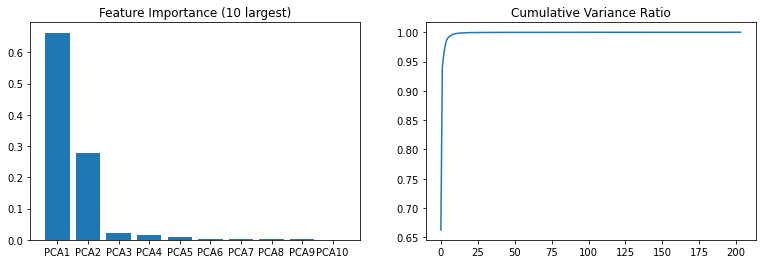

In [28]:
# Find a proper number of 'n_components' by setting a threshold for the variance capture ratio
# Supposed that the threshold equals 99.9%
threshold = 0.99
num_components = find_pca_num_visual(data_to_classify, threshold)
print(f"The number of principle components selected is {num_components}, which captures {threshold*100}% variance of data.")

In [29]:
# Get the data after feature seletion
pca = PCA(n_components=num_components)
data_new_2d = pca.fit_transform(data_to_classify)

In [30]:
num_components

5

## Feature Visualization (After PCA)

### 1. Pairwise scatter plot of feature space after PCA

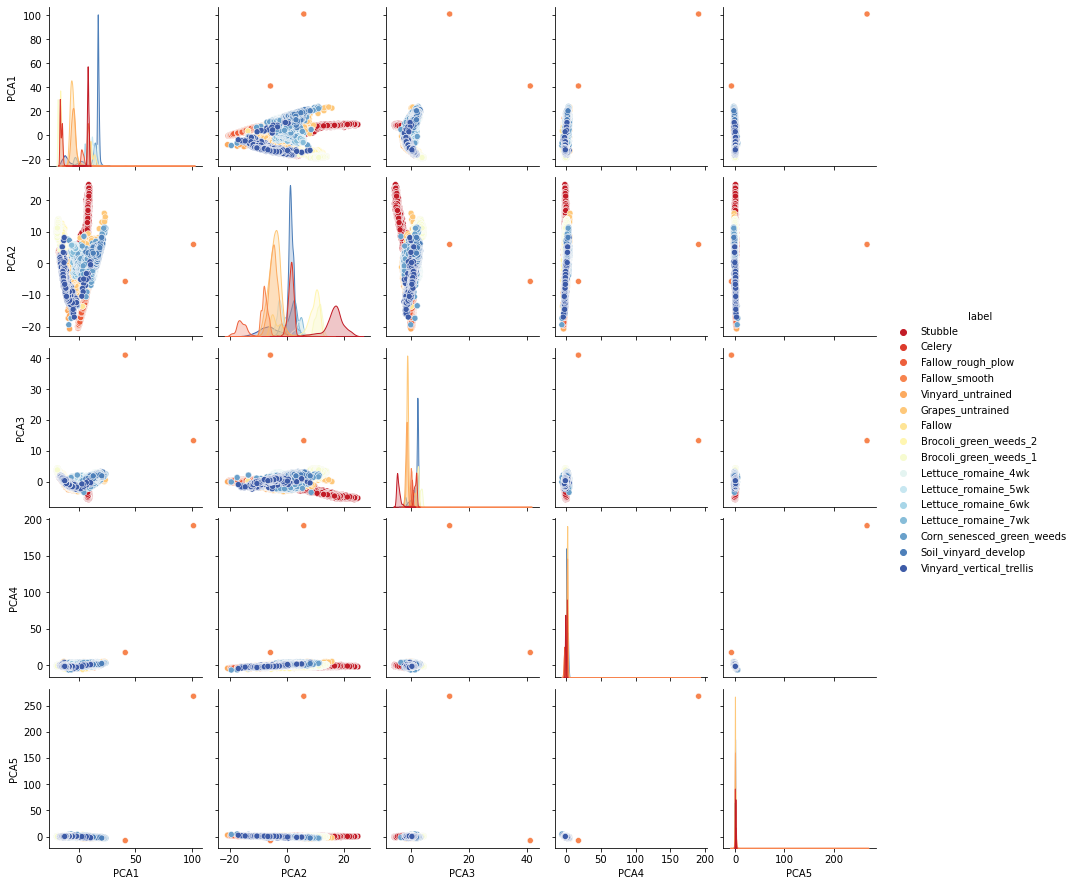

In [63]:
# Pairwise scatter plot
df = pd.DataFrame(data_new_2d)
df = pd.concat([df, pd.DataFrame(label_to_classify.ravel())],axis=1)
df.columns = [f'PCA{i+1}' for i in range(num_components)]+['label']
df.loc[df['label']==1, 'label'] =  'Brocoli_green_weeds_1'
df.loc[df['label']==2, 'label'] =  'Brocoli_green_weeds_2'
df.loc[df['label']==3, 'label'] =  'Fallow'
df.loc[df['label']==4, 'label'] =  'Fallow_rough_plow'
df.loc[df['label']==5, 'label'] =  'Fallow_smooth'
df.loc[df['label']==6, 'label'] =  'Stubble'
df.loc[df['label']==7, 'label'] =  'Celery'
df.loc[df['label']==8, 'label'] =  'Grapes_untrained'
df.loc[df['label']==9, 'label'] =  'Soil_vinyard_develop'
df.loc[df['label']==10, 'label'] =  'Corn_senesced_green_weeds'
df.loc[df['label']==11, 'label'] =  'Lettuce_romaine_4wk'
df.loc[df['label']==12, 'label'] =  'Lettuce_romaine_5wk'
df.loc[df['label']==13, 'label'] =  'Lettuce_romaine_6wk'
df.loc[df['label']==14, 'label'] =  'Lettuce_romaine_7wk'
df.loc[df['label']==15, 'label'] =  'Vinyard_untrained'
df.loc[df['label']==16, 'label'] =  'Vinyard_vertical_trellis'

sns.pairplot(df,hue='label',palette='RdYlBu',diag_kind="kde")

### 2. Boxplot of feature space after PCA

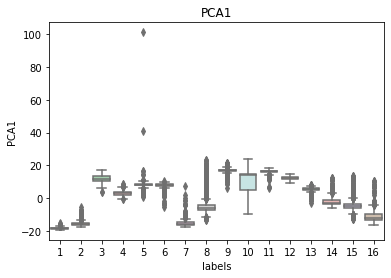

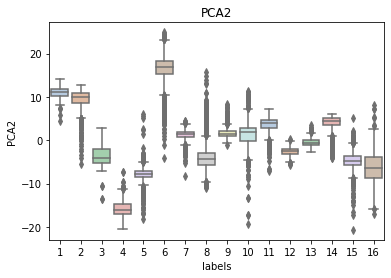

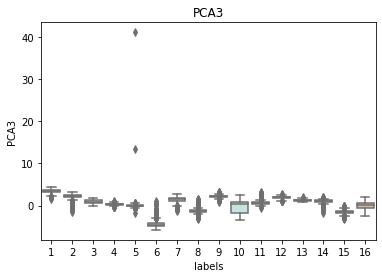

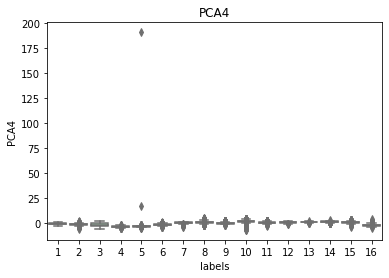

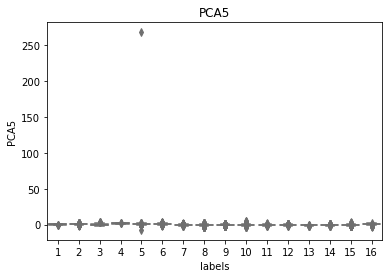

In [73]:
"""
box plot - to compare differences between 
each class's distribution in feature space 

"""
df2 = pd.DataFrame(data_new_2d)
df2.columns = [f'PCA{i}'for i in range(1,num_components+1)]

Salinas_all = df2.copy() #use copy to avoid writing to the original data
Salinas_all['labels'] = label_to_classify #combine features and labels 

for col in df2.columns:
    sns.boxplot(x='labels', y=col, saturation=0.5,palette='pastel', data=Salinas_all)
    plt.title(col)
    plt.show()

## Split into training & test set

The dataset is firstly split into training set(80%) and test set(20%) via sklearn.model_selection.train_test_split  
Then the training set uses the K-Fold metric to perform model validation via sklearn.model_selection.cross_val_score

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(data_new_2d, label_to_classify, test_size=0.2, random_state=88)

In [36]:
print(data_new_2d.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(54129, 5)
(43303, 5)
(10826, 5)
(43303,)
(10826,)


## Random Forest Classifier

In [37]:
# Model building
rf = RandomForestClassifier(random_state=99)

In [38]:
# Parameter Tuning and Cross validation
params_grid = {
    'n_estimators': [50, 100, 200, 300],
#     'class_weight': ['balanced',None],
    'max_features': [3, 4, 5]
}    
clf = GridSearchCV(rf, params_grid, n_jobs=6, verbose=4, cv=5)
clf.fit(X_train, Y_train)
print('Best parameters: ', clf.best_params_)
print('Mean cross validation score of best estimator: ', clf.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters:  {'max_features': 3, 'n_estimators': 200}
Mean cross validation score of best estimator:  0.9226612888387941


In [39]:
# Print the Grid Search Result
dic = {}
dic.update({'param_max_features': clf.cv_results_['param_max_features'],
            'param_n_estimators': clf.cv_results_['param_n_estimators'],
            'mean_test_score':  clf.cv_results_['mean_test_score']})
df = pd.DataFrame(dic)
df

,param_max_features,param_n_estimators,mean_test_score
0,3,50,0.922384
1,3,100,0.922107
2,3,200,0.922661
3,3,300,0.922500
4,4,50,0.920791
5,4,100,0.921507
6,4,200,0.922523
7,4,300,0.922153
8,5,50,0.919890
9,5,100,0.920075


In [40]:
# The model with best parameters
best_rf = clf.best_estimator_
best_rf.fit(X_train,Y_train)

RandomForestClassifier(max_features=3, n_estimators=200, random_state=99)

In [77]:
# Predict the labels for the test set
y_pred = best_rf.predict(X_test)

In [78]:
# Print the prediction accuracy
accuracy = accuracy_score(Y_test,y_pred)
print(accuracy)

0.926473305006466


In [79]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       386
           2       0.99      1.00      1.00       749
           3       0.98      0.99      0.99       385
           4       1.00      1.00      1.00       283
           5       0.99      0.99      0.99       521
           6       1.00      1.00      1.00       778
           7       1.00      1.00      1.00       724
           8       0.83      0.86      0.84      2271
           9       0.99      1.00      0.99      1259
          10       0.95      0.95      0.95       665
          11       0.97      0.95      0.96       245
          12       0.98      0.99      0.99       391
          13       0.99      0.99      0.99       166
          14       0.99      0.98      0.99       215
          15       0.77      0.73      0.75      1423
          16       0.98      0.96      0.97       365

    accuracy                           0.93     10826
   macro avg       0.96   

In [44]:
def plot_histogram_compare_predict_expect(predict, true):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py" 
    '''
    Plot histogram and compare to predictions histogram
    params
    ----------
    predict: Predictions array of shape (n_samples,)
    expect: Expectations array of shape (n_samples,)
    title: Matplotlib title
    '''
    fig, axs = plt.subplots(figsize=(20, 6))

    bar_x, bar_count_pred = np.unique(predict, return_counts=True)
    bar1 = axs.bar(bar_x - 0.2, bar_count_pred, 0.4, label="Predicted")

    bar_x, bar_count_exp = np.unique(true, return_counts=True)
    bar2 = axs.bar(bar_x + 0.2, bar_count_exp, 0.4, label="True")

    axs.bar_label(bar1, padding=3)
    axs.bar_label(bar2, padding=3)

    axs.set_xticks(np.arange(1,len(bar_x)+1))
    axs.set_xticklabels(bar_x)

    axs.set_title('Number of Predicted and True Labels', fontdict={'size':17})
    axs.legend()
    plt.show()

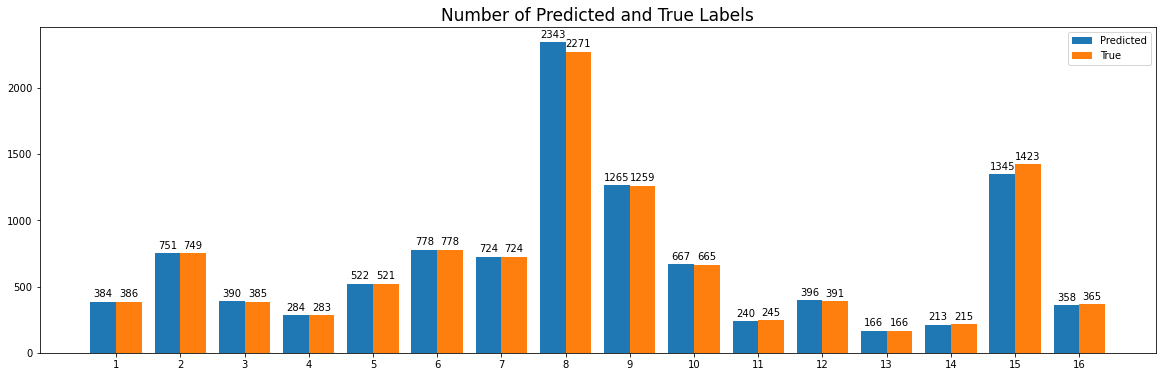

In [45]:
plot_histogram_compare_predict_expect(y_pred,Y_test)

In [48]:
def plot_confusion_matrix(labels, preds, class_names, title='Confusion matrix', log=False):
    # this function is from "plot.py" in "https://github.com/drguigui1/HSI-Classification/blob/main/src/plot.py"
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale
    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('bottom')
    if log:
        sns.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sns.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

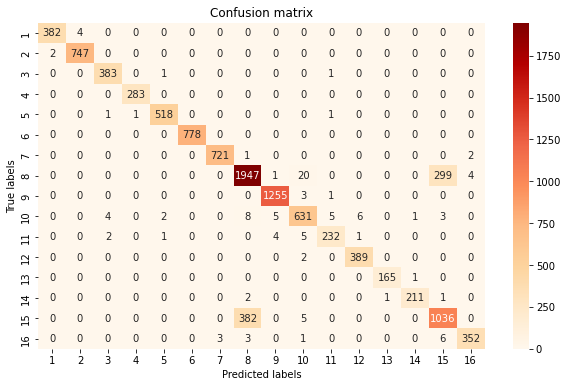

In [49]:
plot_confusion_matrix(Y_test,y_pred,class_names=np.arange(1,17).astype(str),log=False)

## Predict for the whole image

In [50]:
# Prediction for the whole image
y_pred_full = best_rf.predict(data_new_2d)

In [51]:
y_pred_full.shape

(54129,)

In [52]:
# Padding the background for plotting
idx_arr1 = np.argwhere(salinas_labels_1d != 0).flatten()
salinas_img_pred = np.zeros((salinas_labels.shape[0]*salinas_labels.shape[1]))
salinas_img_pred[idx_arr1] = y_pred_full

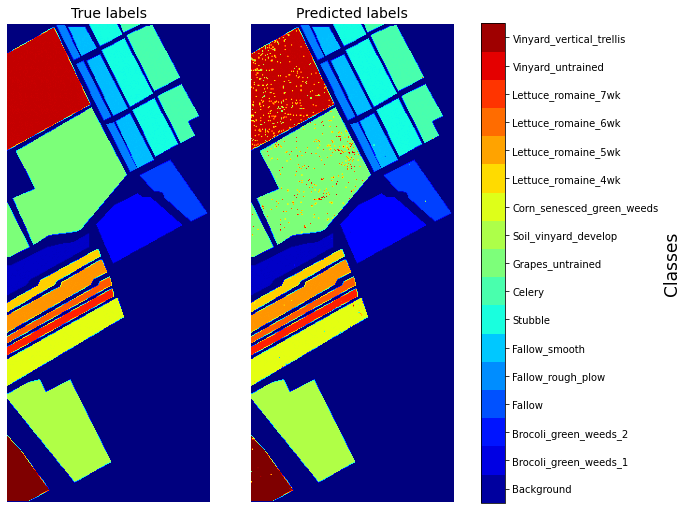

In [53]:
labels = np.dstack((salinas_labels,salinas_img_pred.reshape((salinas_labels.shape[0], salinas_labels.shape[1]))))
titles = ['True labels', 'Predicted labels']
fig, axs = plt.subplots(1, 2, figsize=(10, 14))
for col in range(2):
    ax = axs[col]
    ax.axis('off')
    pcm = ax.imshow(labels[:,:,col], cmap='jet')
    ax.set_title(titles[col],fontdict = {'size':14})
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), ax=axs.ravel().tolist(), boundaries=(np.arange(NUM_CLASSES + 2) - 0.5),shrink=0.63)
cbar.set_label('Classes', fontdict = {'size':17})
cbar.set_ticks(np.arange(NUM_CLASSES + 1))
cbar.set_ticklabels(GROUND_TRUTH)